In [1]:
# GPU setting

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

In [2]:
print(os.environ["CUDA_VISIBLE_DEVICES"])

2,3


In [3]:
!nvidia-smi

Wed Feb  5 05:55:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:1D:00.0 Off |                  N/A |
| 41%   57C    P8    29W / 280W |     11MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:1E:00.0 Off |                  N/A |
| 41%   55C    P8    16W / 280W |     11MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from torchvision import datasets, models, transforms, utils
from matplotlib.pyplot import imshow, imsave
from PIL import Image
from collections import OrderedDict

import copy

import cv2

In [5]:
# utility function to measure time

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [6]:
device = ("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## FirstNet with ASPP

In [7]:
class DilationPyramidPooling(nn.Module):
    def __init__(self, pool_size, in_channels):
        super(DilationPyramidPooling, self).__init__()
        self.pool_size = pool_size
        self.in_channels = in_channels
               
        self.pool_conv = []
        for pool in self.pool_size:
            out_channels = int(self.in_channels/pool)
            self.pool_conv.append(nn.Sequential(
                # dilation pooling
                nn.Conv2d(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=3, dilation=pool, padding=pool, stride=1, bias=False),
                nn.BatchNorm2d(self.in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels, kernel_size=1, bias=True)# dilation=1, padding=(1,1), stride=(1,1), bias=False)
            ))
            
        self.pool_conv = nn.ModuleList(self.pool_conv)

    def forward(self, x):
        #print('x: {}'.format(x.shape))
        y_ = self.pool_conv[0](x)
#         temp = torch.zeros(x.size()).to(device)
#         print('temp: {}'.format(temp.shape))
        out = torch.zeros(len(self.pool_size))
         
#         print('pool_conv modules')
#         print(self.pool_conv)
        
        for i in range(len(self.pool_size)-1):
            temp = self.pool_conv[i+1](x)
#             print('{}th'.format(i))
#             print('temp : {}'.format(temp.shape))
            y_ = torch.cat([y_, temp], dim=1)
#             print('y_ : {}'.format(y_.shape))

       
#         print('out')
#         print(y_.shape)
        
        return y_
        

Blur Pooling

: Concatenation helps the decoder to recover positional data. In this case, the boundary data of original image is critical. For the concatenating images' boundary to be more specific, we introduce Blur Pooling. It generates average blurred images from concatenation image. From average pooling, the boundary data of original image is blurred well. After that, original image is subtracted by blurred image so that the boundary data is emphasized.

In [8]:
class BlurPooling(nn.Module):
    def __init__(self):
        super(BlurPooling, self).__init__()
                
    def forward(self, x):
        blur = torch.zeros(x.size(0), x.size(1), x.size(2), x.size(3))
        blur = blur.detach().numpy()
        img_np = x.cpu().detach().numpy()
        #blur = np.zeros([img_np.size(0),img_np.size(1), img_np.size(2), img_np.size(3)])
        #print('input_img')
        #print(img_np.shape)
        for i in range(x.size(0)):
            for j in range(x.size(1)):
                blur[i][j] = cv2.blur(img_np[i][j], (8,16))
        #blur = cv2.blur(img_np, (8,16))
        y_ = img_np - 1*blur
        y_ = torch.from_numpy(y_).float().to(device)
    
        return y_

In [9]:
# KMNet_vgg16bn: atros, index pooling(segnet), no blur pooling mod, until pool3

class FirstNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=34):
        super(FirstNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
                      
        #cityscape input (-1, 3,1024, 2048)
              
        self.encoder1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=(7,7), stride=(1,1), padding=(3,3), dilation=(1,1),bias=False)),
            ('bn1', nn.BatchNorm2d(32)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), dilation=(1,1),bias=False)),
            ('bn2', nn.BatchNorm2d(32)),
            ('relu2', nn.ReLU(inplace=True))
        ]))
                                                    
        self.pooling1 = DilationPyramidPooling(in_channels=64, pool_size=(1,2))
        self.encoder2 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=1,padding=1,bias=False)),
            ('bn1', nn.BatchNorm2d(64)),
            ('relu1', nn.ReLU(inplace=True)),
            
        ]))
                                      
        self.pooling2 = DilationPyramidPooling(in_channels=128, pool_size=(1,2,4))
        self.encoder3 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=224, out_channels=128, kernel_size=3, stride=1,padding=1,bias=False)),
            ('bn1', nn.BatchNorm2d(128)),
            ('relu1', nn.ReLU(inplace=True)),
            
        ]))
        
        #self.downsample = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=True)
        self.downsample1 = nn.Sequential(OrderedDict([
            ('downconv1',nn.Conv2d(in_channels=32, out_channels=64 , kernel_size=(3,3), stride = (2,2), padding = (1,1))),
            ('bn1',nn.BatchNorm2d(64)),
        ]))
        
        self.downsample2 = nn.Sequential(OrderedDict([
            ('downconv1',nn.Conv2d(in_channels=64, out_channels=128 , kernel_size=(3,3), stride = (2,2), padding = (1,1))),
            ('bn1',nn.BatchNorm2d(128)),
        ]))
        
        self.downsample3 = nn.Sequential(OrderedDict([
            ('downconv1',nn.Conv2d(in_channels=128, out_channels=256 , kernel_size=(3,3), stride = (2,2), padding = (1,1))),
            ('bn1',nn.BatchNorm2d(256)),
        ]))
        
        #self.upsample = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)   # input size * 2
        self.upsample1 = nn.Sequential(OrderedDict([
            ('deconv1',nn.ConvTranspose2d(in_channels=256, out_channels=128 , kernel_size=(4,4), stride = (2,2), padding = (1,1), bias=False)),
            ('bn1',nn.BatchNorm2d(128)),
        ]))
        
        self.upsample2 = nn.Sequential(OrderedDict([
            ('deconv1',nn.ConvTranspose2d(in_channels=128, out_channels=64 , kernel_size=(4,4), stride = (2,2), padding = (1,1), bias=False)),
            ('bn1',nn.BatchNorm2d(64)),
        ]))
        
        self.upsample3 = nn.Sequential(OrderedDict([
            ('deconv1',nn.ConvTranspose2d(in_channels=64, out_channels=32 , kernel_size=(4,4), stride = (2,2), padding = (1,1), bias=False)),
            ('bn1',nn.BatchNorm2d(32)),
        ]))
        
        self.blurpool = BlurPooling()
        
        self.decoder1 = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)),
            ('bn1',nn.BatchNorm2d(256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('conv2',nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)),
            ('bn2', nn.BatchNorm2d(256)),
            ('relu2', nn.ReLU(inplace=True)),
        ]))
        
        self.decoder2 = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(in_channels=259, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)),
            ('bn1',nn.BatchNorm2d(256)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2',nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)),
            ('bn2', nn.BatchNorm2d(128)),
            ('relu2',nn.ReLU(inplace=True)),
        ]))
        
        self.decoder3 = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(in_channels=131, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)),
            ('bn1',nn.BatchNorm2d(128)),
            ('relu1',nn.ReLU(inplace=True)),
            ('conv2',nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=(1,1), bias=False)),
            ('bn2',nn.BatchNorm2d(64)),
            ('relu2',nn.ReLU(inplace=True)),
        ]))
        
        self.last_conv = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(in_channels=67, out_channels=64, kernel_size=(3,3), padding=(1,1), bias=False)),
            ('bn1',nn.BatchNorm2d(64)),
            ('relu1',nn.ReLU(inplace=True)),
            ('conv2',nn.Conv2d(in_channels=64, out_channels=n_classes, kernel_size=(1,1))),
        ]))
        
        
    def forward(self, x):
        #divide and blur the image first
        x_blur = self.blurpool(x)
        x_div2 = F.interpolate(x, size=(256, 512))
        x_div2_blur = self.blurpool(x_div2)
#         print('x_div2')
#         print(x_div2.shape)
        x_div4 = F.interpolate(x, size=(128, 256))
        x_div4_blur = self.blurpool(x_div4)
#         print('x_div4')
#         print(x_div4.shape)
        
                                      
        # Encoder
        y_1_enc = self.encoder1(x)
#         print('y1')
#         print(y_1_enc.shape)
        y_1_down= self.downsample1(y_1_enc)
#         print('y_1_down')
#         print(y_1_down.shape)
#         print('idx1')
#         print(idx1.shape)
        
        y_2_pool = self.pooling1(y_1_down)
#         print('y2_pool')
#         print(y_2_pool.shape)
        y_2_enc = self.encoder2(y_2_pool)
#         print('y2_enc')
#         print(y_2_enc.shape)                             
        y_2_down = self.downsample2(y_2_enc)
#         print('y2_down')
#         print(y_2_down.shape)
#         print('idx2')
#         print(idx2.shape)
        
        y_3_pool = self.pooling2(y_2_down)   
#         print('y3_pool')
#         print(y_3_pool.shape)
        y_3_enc = self.encoder3(y_3_pool)
#         print('y3_enc')
#         print(y_3_enc.shape)
        y_3_down= self.downsample3(y_3_enc)
#         print('y3_down')
#         print(y_3_down.shape)
#         print('idx3')
#         print(idx3.shape)
        

        # Decoder
        d_1 = self.decoder1(y_3_down)
#         print('d_1')
#         print(d_1.shape)
        d_1_up = self.upsample1(d_1)
#         print('d_1_up')
#         print(d_1_up.shape)
        
        
        d_2_concat = torch.cat((d_1_up,y_3_enc,x_div4_blur), dim=1)
#         print('1st concat ok')
#         print('d2_concat')
#         print(d_2_concat.shape)
        d_2 = self.decoder2(d_2_concat)
#         print('2nd deco ok')
#         print('d2_deco')
#         print(d_2.shape)
        d_2_up = self.upsample2(d_2)
#         print('d2_up')
#         print(d_2_up.shape)
        
        d_3_concat = torch.cat((d_2_up, y_2_enc, x_div2_blur), dim=1)
#         print('2nd concat ok')
#         print('d3_concat')
#         print(d_3_concat.shape)
        d_3 = self.decoder3(d_3_concat)
#         print('3rd deco ok')
#         print('d3_deco')
#         print(d_3.shape)
        d_3_up = self.upsample3(d_3)
#         print('d3_up')
#         print(d_3.shape)
                

        last_concat = torch.cat((d_3_up,y_1_enc,x_blur), dim=1)
#         print('3rd concat ok')
#         print('last_concat')
#         print(last_concat.shape)
        
        y_ = self.last_conv(last_concat)
#         print('last conv')
#         print(y_.shape)
#         y_ = F.interpolate(y_, (x.size(-2), x.size(-1)), mode='bilinear', align_corners=True)
#         print('interpolation')
#         print(y_.shape)

        
        return y_

In [10]:
model = FirstNet(n_classes=34).to(device)
print(model)


FirstNet(
  (encoder1): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
  )
  (pooling1): DilationPyramidPooling(
    (pool_conv): ModuleList(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
        (1): BatchNorm2d(

In [11]:
from torchsummary import summary

summary(model, input_size=(3,512,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BlurPooling-1         [-1, 3, 512, 1024]               0
       BlurPooling-2          [-1, 3, 256, 512]               0
       BlurPooling-3          [-1, 3, 128, 256]               0
            Conv2d-4        [-1, 32, 512, 1024]           4,704
       BatchNorm2d-5        [-1, 32, 512, 1024]              64
              ReLU-6        [-1, 32, 512, 1024]               0
            Conv2d-7        [-1, 32, 512, 1024]           9,216
       BatchNorm2d-8        [-1, 32, 512, 1024]              64
              ReLU-9        [-1, 32, 512, 1024]               0
           Conv2d-10         [-1, 64, 256, 512]          18,496
      BatchNorm2d-11         [-1, 64, 256, 512]             128
           Conv2d-12         [-1, 64, 256, 512]          36,864
      BatchNorm2d-13         [-1, 64, 256, 512]             128
             ReLU-14         [-1, 64, 2

In [15]:
class MaskToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.int32)).long()

In [16]:
img_transform = transforms.Compose([
#     transforms.Resize(size=(520,1040)),
#     transforms.RandomCrop(size=(512,1024), padding_mode='constant'),
#     transforms.RandomHorizontalFlip(0.5),
    transforms.Resize(size=(512,1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.28689554, 0.32513303, 0.28389177], std=[0.18696375, 0.19017339, 0.18720214]),
])

In [17]:
target_transform = transforms.Compose([
    transforms.Resize(size=(512,1024)),
    MaskToTensor(),
])

In [18]:
def getMeanIoU(label, yhat, n_classes=34, ignore_class=[0,1,2,3,4,5,6,9,10,14,15,16,18,29,30]):
    if ignore_class==None:
        ignore_len = 0
    else:
        ignore_len = len(ignore_class)
    iou = np.zeros(n_classes-ignore_len)
    minus = 0
    for i in range(n_classes):
        if np.isin(i, ignore_class):
            minus+=1
            continue
#         print(i-minus)
        tfpn = torch.eq(yhat, i)
    

        tp = len(tfpn[(tfpn==True) & (label==i) &(yhat==i)])
        fp = len(tfpn[(tfpn==True) & (label!=i) & (yhat==i)])
        fn = len(tfpn[(tfpn==False) & (label==i) & (yhat!=i)])
        tn = len(tfpn[(tfpn==False) & (label!=i) & (yhat!=i)])
        
        if tp==0:
            iou[i-minus] = 0.0
        else:
            iou[i-minus] = tp/(tp+fp+fn)
#         print(iou[i-minus])
            
    mIoU = np.mean(iou)
#     print(iou)
    
    return mIoU

In [19]:
train_set = datasets.Cityscapes(root='/root/km/data/cityscapes', split='train', mode='fine', target_type='semantic', transform=img_transform, target_transform=target_transform)
val_set = datasets.Cityscapes(root='/root/km/data/cityscapes', split='val', mode='fine', target_type='semantic', transform=img_transform, target_transform=target_transform)

In [20]:
len(train_set)

2975

In [21]:
train_set[0][0].shape

torch.Size([3, 512, 1024])

In [22]:
val_set[0][0].shape

torch.Size([3, 512, 1024])

## Using multi-GPUs

In [23]:
print(torch.cuda.device_count())

2


In [24]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): FirstNet(
    (encoder1): Sequential(
      (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (pooling1): DilationPyramidPooling(
      (pool_conv): ModuleList(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [25]:
batch_size = 8
learning_rate = 0.01

In [26]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_set, batch_size=10, shuffle=False, drop_last=False)

In [27]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
max_iter = 90000
max_epoch = max_iter//(len(train_set)//batch_size)
step = 0

In [29]:
from torch.optim.lr_scheduler import _LRScheduler

class PolyLR(_LRScheduler):
    def __init__(self, optimizer, max_iter, power=0.9, last_epoch=-1):
        self.max_iter = max_iter
        self.power = power
        super(PolyLR, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        return [base_lr*(1-self.last_epoch/self.max_iter)**self.power 
                for base_lr in self.base_lrs]
    


In [30]:
#from torch.optim.lr_scheduler import StepLR
#scheduler = StepLR(optim, step_size=50, gamma=0.9)
scheduler = PolyLR(optim, max_iter = max_iter)

## Train

In [ ]:
# new blur

totalLoss = 0
trainLoss = []

best_model_wts = copy.deepcopy(model.state_dict())
best_miou = 0
#out = open('vgg16bn_layer3_newblur_mod_history.txt','w+')

# interrupt 했다가 다시 돌릴거면 여기를 on
out = open('FirstNet_200204_history.txt','a+')
model.train()
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        out = open('FirstNet_200204_history.txt','a')
        start = time.time()
        x, y = images.to(device), labels.to(device)
        yhat = model(x)
#         print(epoch,step)
        
        loss = criterion(yhat.type(torch.float), y)
        totalLoss += loss.item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        scheduler.step()
        
        if (step+1)%5 == 0:
            print('{}th Epoch, {}th Step, learning rate = {} - Loss: {}'.format(epoch+1, step+1, scheduler.get_lr()[0], loss.item()), file=out)
            print('{}th Epoch, {}th Step, learning rate = {} - Loss: {}'.format(epoch+1, step+1, scheduler.get_lr()[0], loss.item()))
            trainLoss.append(totalLoss/5)
            totalLoss = 0
            
        if (step+1)%100 == 0:
            model.eval()
            print('<{}th step>'.format(step+1),file=out)
            print('<{}th step>'.format(step+1))
            mIoU = 0
            curr = 0
            y_all, y_pred_all = torch.Tensor([]).type(torch.long), torch.Tensor([]).type(torch.long)
            with torch.no_grad():
                for idx, (images, labels) in enumerate(val_loader):
                    x, y = images.to(device), labels.to(device)
                    yhat = model(x)
                    
                    loss = criterion(yhat, y)

                    _, y_pred = torch.max(yhat.cpu(), dim=1)
                    
                    y_all = torch.cat([y_all, y.cpu()])
                    y_pred_all = torch.cat([y_pred_all, y_pred.cpu()])
                    
                    
                    curr += len(y)
                    if (curr%20) == 0:
                        print(curr, end=' ')
                    
                    
            mIoU = getMeanIoU(y_all.to(device), y_pred_all.to(device))
            print()
            print('*'*27, 'Test', '*'*27,file=out)
            print('*'*27, 'Test', '*'*27)
            print('time:{}, {}th Step, Loss: {}, Mean IoU = {:.3f}%'.format(timeSince(start), step+1, loss.item(), mIoU*100), file=out)
            print('time:{}, {}th Step, Loss: {}, Mean IoU = {:.3f}%'.format(timeSince(start), step+1, loss.item(), mIoU*100))
            print('*'*60,file=out)
            print('*'*60)
            
            model.train()
        
        step+=1
        

1th Epoch, 5th Step, learning rate = 0.009999499998611083 - Loss: 2.505260944366455
1th Epoch, 10th Step, learning rate = 0.00999899999444422 - Loss: 2.1543588638305664
1th Epoch, 15th Step, learning rate = 0.009998499987499236 - Loss: 2.248898506164551
1th Epoch, 20th Step, learning rate = 0.009997999977775967 - Loss: 1.8624188899993896
1th Epoch, 25th Step, learning rate = 0.00999749996527424 - Loss: 1.9007773399353027
1th Epoch, 30th Step, learning rate = 0.009996999949993889 - Loss: 1.6950082778930664
1th Epoch, 35th Step, learning rate = 0.009996499931934738 - Loss: 1.98507559299469
1th Epoch, 40th Step, learning rate = 0.009995999911096622 - Loss: 1.6980184316635132
1th Epoch, 45th Step, learning rate = 0.009995499887479371 - Loss: 1.5570403337478638
1th Epoch, 50th Step, learning rate = 0.00999499986108281 - Loss: 1.796292781829834
1th Epoch, 55th Step, learning rate = 0.009994499831906777 - Loss: 1.7706845998764038
1th Epoch, 60th Step, learning rate = 0.009993999799951093 - Lo

2th Epoch, 415th Step, learning rate = 0.009958490415728069 - Loss: 1.100340723991394
2th Epoch, 420th Step, learning rate = 0.009957990183189908 - Loss: 1.241662621498108
2th Epoch, 425th Step, learning rate = 0.00995748994785964 - Loss: 0.9616482853889465
2th Epoch, 430th Step, learning rate = 0.009956989709737095 - Loss: 0.8618321418762207
2th Epoch, 435th Step, learning rate = 0.009956489468822096 - Loss: 1.1593104600906372
2th Epoch, 440th Step, learning rate = 0.009955989225114478 - Loss: 1.1533522605895996
2th Epoch, 445th Step, learning rate = 0.009955488978614068 - Loss: 1.294070839881897
2th Epoch, 450th Step, learning rate = 0.00995498872932069 - Loss: 1.1089624166488647
2th Epoch, 455th Step, learning rate = 0.009954488477234178 - Loss: 1.1343610286712646
2th Epoch, 460th Step, learning rate = 0.00995398822235436 - Loss: 1.152837872505188
2th Epoch, 465th Step, learning rate = 0.00995348796468106 - Loss: 0.9540678858757019
2th Epoch, 470th Step, learning rate = 0.0099529877

3th Epoch, 820th Step, learning rate = 0.009917962519048888 - Loss: 1.2457550764083862
3th Epoch, 825th Step, learning rate = 0.009917462059792858 - Loss: 0.9436310529708862
3th Epoch, 830th Step, learning rate = 0.009916961597730768 - Loss: 1.0125380754470825
3th Epoch, 835th Step, learning rate = 0.009916461132862446 - Loss: 0.8555920124053955
3th Epoch, 840th Step, learning rate = 0.00991596066518772 - Loss: 0.8104740977287292
3th Epoch, 845th Step, learning rate = 0.009915460194706415 - Loss: 0.913247287273407
3th Epoch, 850th Step, learning rate = 0.009914959721418357 - Loss: 0.8972644805908203
3th Epoch, 855th Step, learning rate = 0.009914459245323377 - Loss: 1.0255769491195679
3th Epoch, 860th Step, learning rate = 0.009913958766421297 - Loss: 0.9495536684989929
3th Epoch, 865th Step, learning rate = 0.009913458284711945 - Loss: 1.0219016075134277
3th Epoch, 870th Step, learning rate = 0.00991295780019515 - Loss: 0.8046520948410034
3th Epoch, 875th Step, learning rate = 0.00991

4th Epoch, 1225th Step, learning rate = 0.009877416212877613 - Loss: 0.7905412912368774
4th Epoch, 1230th Step, learning rate = 0.00987691552576827 - Loss: 1.0034809112548828
4th Epoch, 1235th Step, learning rate = 0.00987641483583878 - Loss: 0.9955987930297852
4th Epoch, 1240th Step, learning rate = 0.009875914143088972 - Loss: 0.8444014191627502
4th Epoch, 1245th Step, learning rate = 0.009875413447518671 - Loss: 0.901655912399292
4th Epoch, 1250th Step, learning rate = 0.0098749127491277 - Loss: 1.0544493198394775
4th Epoch, 1255th Step, learning rate = 0.009874412047915884 - Loss: 0.774803102016449
4th Epoch, 1260th Step, learning rate = 0.00987391134388305 - Loss: 0.7446008324623108
4th Epoch, 1265th Step, learning rate = 0.009873410637029022 - Loss: 0.7808681726455688
4th Epoch, 1270th Step, learning rate = 0.009872909927353625 - Loss: 0.7912956476211548
4th Epoch, 1275th Step, learning rate = 0.009872409214856687 - Loss: 0.8899132609367371
4th Epoch, 1280th Step, learning rate =

5th Epoch, 1625th Step, learning rate = 0.009837352318082901 - Loss: 0.862719714641571
5th Epoch, 1630th Step, learning rate = 0.009836851404808085 - Loss: 0.9486368894577026
5th Epoch, 1635th Step, learning rate = 0.009836350488699078 - Loss: 0.9671400785446167
5th Epoch, 1640th Step, learning rate = 0.009835849569755707 - Loss: 0.7801870703697205
5th Epoch, 1645th Step, learning rate = 0.00983534864797779 - Loss: 0.7983453869819641
5th Epoch, 1650th Step, learning rate = 0.009834847723365157 - Loss: 0.9204098582267761
5th Epoch, 1655th Step, learning rate = 0.009834346795917628 - Loss: 0.743583083152771
5th Epoch, 1660th Step, learning rate = 0.009833845865635025 - Loss: 0.9387719035148621
5th Epoch, 1665th Step, learning rate = 0.009833344932517175 - Loss: 0.6510611772537231
5th Epoch, 1670th Step, learning rate = 0.0098328439965639 - Loss: 1.1884546279907227
5th Epoch, 1675th Step, learning rate = 0.009832343057775023 - Loss: 0.6275405287742615
5th Epoch, 1680th Step, learning rate

6th Epoch, 2025th Step, learning rate = 0.00979727028553129 - Loss: 0.7575806379318237
6th Epoch, 2030th Step, learning rate = 0.009796769144962124 - Loss: 0.7092284560203552
6th Epoch, 2035th Step, learning rate = 0.009796268001544591 - Loss: 0.5008760094642639
6th Epoch, 2040th Step, learning rate = 0.00979576685527851 - Loss: 0.7308642864227295
6th Epoch, 2045th Step, learning rate = 0.009795265706163705 - Loss: 0.8335333466529846
6th Epoch, 2050th Step, learning rate = 0.009794764554199996 - Loss: 0.850510835647583
6th Epoch, 2055th Step, learning rate = 0.009794263399387207 - Loss: 0.9350306391716003
6th Epoch, 2060th Step, learning rate = 0.009793762241725158 - Loss: 0.6302881836891174
6th Epoch, 2065th Step, learning rate = 0.00979326108121367 - Loss: 0.8055259585380554
6th Epoch, 2070th Step, learning rate = 0.009792759917852568 - Loss: 1.021833896636963
6th Epoch, 2075th Step, learning rate = 0.00979225875164167 - Loss: 0.6328120231628418
6th Epoch, 2080th Step, learning rate 

7th Epoch, 2425th Step, learning rate = 0.00975717002448697 - Loss: 0.6416048407554626
7th Epoch, 2430th Step, learning rate = 0.009756668655483776 - Loss: 0.768834114074707
7th Epoch, 2435th Step, learning rate = 0.009756167283617898 - Loss: 0.8698415160179138
7th Epoch, 2440th Step, learning rate = 0.009755665908889157 - Loss: 0.7538962960243225
7th Epoch, 2445th Step, learning rate = 0.009755164531297373 - Loss: 0.6242491006851196
7th Epoch, 2450th Step, learning rate = 0.009754663150842363 - Loss: 0.5313124060630798
7th Epoch, 2455th Step, learning rate = 0.009754161767523953 - Loss: 0.5574333667755127
7th Epoch, 2460th Step, learning rate = 0.009753660381341959 - Loss: 0.9331185817718506
7th Epoch, 2465th Step, learning rate = 0.009753158992296201 - Loss: 0.5934212803840637
7th Epoch, 2470th Step, learning rate = 0.009752657600386502 - Loss: 0.8376290202140808
7th Epoch, 2475th Step, learning rate = 0.00975215620561268 - Loss: 0.9304724335670471
7th Epoch, 2480th Step, learning ra

8th Epoch, 2825th Step, learning rate = 0.009717051443343611 - Loss: 0.7811088562011719
8th Epoch, 2830th Step, learning rate = 0.00971654984475575 - Loss: 0.7497202754020691
8th Epoch, 2835th Step, learning rate = 0.009716048243290748 - Loss: 0.6005538702011108
8th Epoch, 2840th Step, learning rate = 0.00971554663894843 - Loss: 0.6077132821083069
8th Epoch, 2845th Step, learning rate = 0.009715045031728611 - Loss: 0.6505078077316284
8th Epoch, 2850th Step, learning rate = 0.009714543421631113 - Loss: 0.6154478192329407
8th Epoch, 2855th Step, learning rate = 0.00971404180865575 - Loss: 0.6712983846664429
8th Epoch, 2860th Step, learning rate = 0.009713540192802341 - Loss: 0.6609867811203003
8th Epoch, 2865th Step, learning rate = 0.009713038574070708 - Loss: 1.1747729778289795
8th Epoch, 2870th Step, learning rate = 0.009712536952460667 - Loss: 0.6876105070114136
8th Epoch, 2875th Step, learning rate = 0.009712035327972034 - Loss: 0.6893092393875122
8th Epoch, 2880th Step, learning ra

9th Epoch, 3225th Step, learning rate = 0.009676914449611973 - Loss: 0.5503798127174377
9th Epoch, 3230th Step, learning rate = 0.009676412620277684 - Loss: 0.5923545360565186
9th Epoch, 3235th Step, learning rate = 0.009675910788051665 - Loss: 0.4800547957420349
9th Epoch, 3240th Step, learning rate = 0.009675408952933734 - Loss: 0.7679303884506226
9th Epoch, 3245th Step, learning rate = 0.009674907114923706 - Loss: 0.5427910089492798
9th Epoch, 3250th Step, learning rate = 0.0096744052740214 - Loss: 0.7388153076171875
9th Epoch, 3255th Step, learning rate = 0.00967390343022663 - Loss: 0.6175029277801514
9th Epoch, 3260th Step, learning rate = 0.009673401583539212 - Loss: 0.5240238308906555
9th Epoch, 3265th Step, learning rate = 0.009672899733958965 - Loss: 0.5920839905738831
9th Epoch, 3270th Step, learning rate = 0.009672397881485705 - Loss: 0.6786854267120361
9th Epoch, 3275th Step, learning rate = 0.009671896026119248 - Loss: 0.5609546899795532
9th Epoch, 3280th Step, learning ra

10th Epoch, 3620th Step, learning rate = 0.009637261008254744 - Loss: 0.6841332912445068
10th Epoch, 3625th Step, learning rate = 0.00963675894990728 - Loss: 0.4902386963367462
10th Epoch, 3630th Step, learning rate = 0.009636256888653535 - Loss: 0.6100760102272034
10th Epoch, 3635th Step, learning rate = 0.009635754824493326 - Loss: 0.6055715084075928
10th Epoch, 3640th Step, learning rate = 0.009635252757426467 - Loss: 0.5579228401184082
10th Epoch, 3645th Step, learning rate = 0.009634750687452773 - Loss: 0.5694029331207275
10th Epoch, 3650th Step, learning rate = 0.009634248614572058 - Loss: 0.6092967987060547
10th Epoch, 3655th Step, learning rate = 0.00963374653878414 - Loss: 0.7880989909172058
10th Epoch, 3660th Step, learning rate = 0.00963324446008883 - Loss: 0.6417791247367859
10th Epoch, 3665th Step, learning rate = 0.009632742378485945 - Loss: 0.6894849538803101
10th Epoch, 3670th Step, learning rate = 0.0096322402939753 - Loss: 0.4820106327533722
10th Epoch, 3675th Step, l

## Extract filter weights

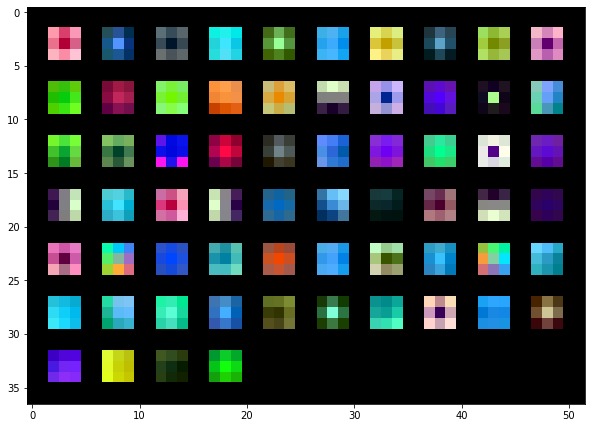

In [38]:
w = model.module.encoder1[0].weight.data
grid = utils.make_grid(w, nrow=10, normalize=True, scale_each=True)

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu())

In [84]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [89]:
res = model.module.decoder1.conv1.register_forward_hook(get_activation('conv1'))
act = activation['conv1'].squeeze()
num_plot = 4
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

KeyError: 'conv1'

In [88]:
res

In [79]:
def custom_viz(kernels, path=None, cols=None, size=None, verbose=False, axis=False):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: Number of columns (doesn't work completely yet.)
    size: Tuple input for size. For example: size=(5,5)
    verbose: Print information about the input.
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]
    total_cols = N*C
    pos = range(1,total_cols + 1)
    
    if verbose:
        print("Shape of input: ", kernels.shape)
        
    if cols==None:
        req_cols = C
        num_rows = N
    elif cols:
        req_cols = cols
        # Account for more rows while diving total cols
        # with requested number of cols in the figure
        # Hence, using np.ceil to get the largest int
        # from the quotient of division.
        num_rows = int(np.ceil(total_cols/req_cols))
    elif C>1:
        # Check for 1D arrays and such. Mostly not needed.
        req_cols = C
    
    fig = plt.figure(1)
    #fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(num_rows,req_cols,pos[k])
            ax.imshow(img, cmap='jet')
            if axis:
                plt.axis('on')
            elif axis==False:
                plt.axis('off')
            k = k+1
    if size:
        size_h,size_w = size
        set_size(size_h,size_w,ax)
    if path:
        plt.savefig(path, dpi=300)
    plt.show()

In [80]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
number = example_data[4]
number.unsqueeze_(0)
number = Variable(number, requires_grad=True)

Shape of input:  torch.Size([1, 64, 504, 1008])


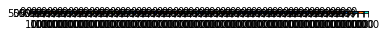

In [81]:
conv1_out = model.module.encoder1[0].forward(number.cuda())
custom_viz(conv1_out.cpu().detach().clone(), 'results/conv1_actv.png', axis=True, verbose=True)

## History
- 20200127: PSPNet: res34+PSP_model.pth about 15500 steps, 51.113%
- 20200130: UNet: KMNet_vgg19bn.pth, about 15000 steps, 45%
- 20200131: KMNet_vgg16bn_200131_layer4.pth, 6200 steps, 30.973%
- 20200204 : KMNet :KMNet_vgg16bn_200202_layer3_noblur_mod.pth(atrous, seg, U, no blur)- about 16410 steps, 39.519%

## model save

In [47]:
PATH = '/root/km/models/FirstNet/FirstNet_200205.pth'
torch.save(model.state_dict(), PATH)


## model load

In [30]:
FirstNet_model = model
FirstNet_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## validation

In [28]:
start = time.time()
FirstNet_model.eval()
print('<{}th step>'.format(step+1))
mIoU = 0
curr = 0
y_all, y_pred_all = torch.Tensor([]).type(torch.long), torch.Tensor([]).type(torch.long)
with torch.no_grad():
    for idx, (images, labels) in enumerate(val_loader):
        x, y = images.to(device), labels.to(device)
        yhat = FirstNet_model(x)

        loss = criterion(yhat, y)

        _, y_pred = torch.max(yhat.cpu(), dim=1)

        y_all = torch.cat([y_all, y.cpu()])
        y_pred_all = torch.cat([y_pred_all, y_pred.cpu()])


        curr += len(y)
        if (curr%20) == 0:
            print(curr, end=' ')


mIoU = getMeanIoU(y_all.to(device), y_pred_all.to(device))
print()
print('*'*27, 'Test', '*'*27)
print('time:{}, {}th Step, Loss: {}, Mean IoU = {:.3f}%'.format(timeSince(start), step+1, loss.item(), mIoU*100))
print('*'*60)
            

<16410th step>
20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 
*************************** Test ***************************
time:3m 10s, 16410th Step, Loss: 0.6485119462013245, Mean IoU = 39.519%
************************************************************


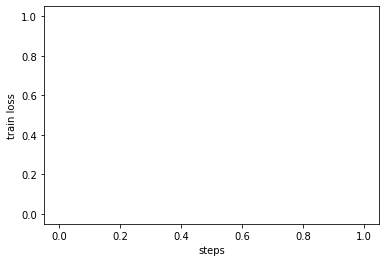

In [35]:
plt.plot(range(len(trainLoss)), trainLoss, marker='.')
plt.xlabel("steps")
plt.ylabel("train loss")
plt.show()

## visualization

In [ ]:
def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))



In [ ]:
def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
    '''
    savetensor: save tensor
        @filename: file name
        @ch: visualization channel 
        @allkernels: visualization all tensores
    '''    

    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    utils.save_image(tensor, filename, nrow=nrow )


In [ ]:
ik = 0
kernel = model.features[ik].weight.data.clone()
print(kernel.shape)

vistensor(kernel, ch=0, allkernels=False)
savetensor(kernel,'kernel.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

## test

In [48]:
test_data = datasets.Cityscapes(root='/root/km/data/cityscapes', split='test', mode='fine', target_type='semantic', transform=img_transform, target_transform=target_transform)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=False, drop_last=False)

In [32]:
print(len(test_data))

1525


In [33]:
KMNet_model = model
KMNet_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
KMNet_model.eval()
print('<{}th step>'.format(step+1))

curr = 0
y_preds = torch.Tensor([]).type(torch.long)
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        x, y =images.to(device), labels.to(device)
        yhat = KMNet_model(x)
        
        loss = criterion(yhat, y)
        
        _, y_pred = torch.max(yhat.cpu(), dim=1)
        y_preds = torch.cat([y_preds, y_pred], dim=0)
        curr += len(y)
        if(curr%50)==0 or curr==len(test_data):
            print(curr, end=' ')
            
print("Prediction Ended")

<16410th step>
50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1525 Prediction Ended


In [35]:
test_img = datasets.Cityscapes(root='/root/km/data/cityscapes', split='test', mode='fine', target_type='semantic')

In [36]:
class TensorToMask(object):
    def __call__(self, tensor):
        mask = tensor.type(torch.uint8)
        
        return mask

In [37]:
class TestTransform(object):
    def __call__(self, tensor, size=(1024, 2048)):
        test_transform = transforms.Compose([
            TensorToMask(),
            transforms.ToPILImage(),
            transforms.Resize(size=size),
        ])
        
        return test_transform(tensor)

In [38]:
test_transform = transforms.Compose([
    TensorToMask(),
    transforms.ToPILImage(),
    transforms.Resize(size=(1024,2048)),
])


In [39]:
a, b = 15, 30

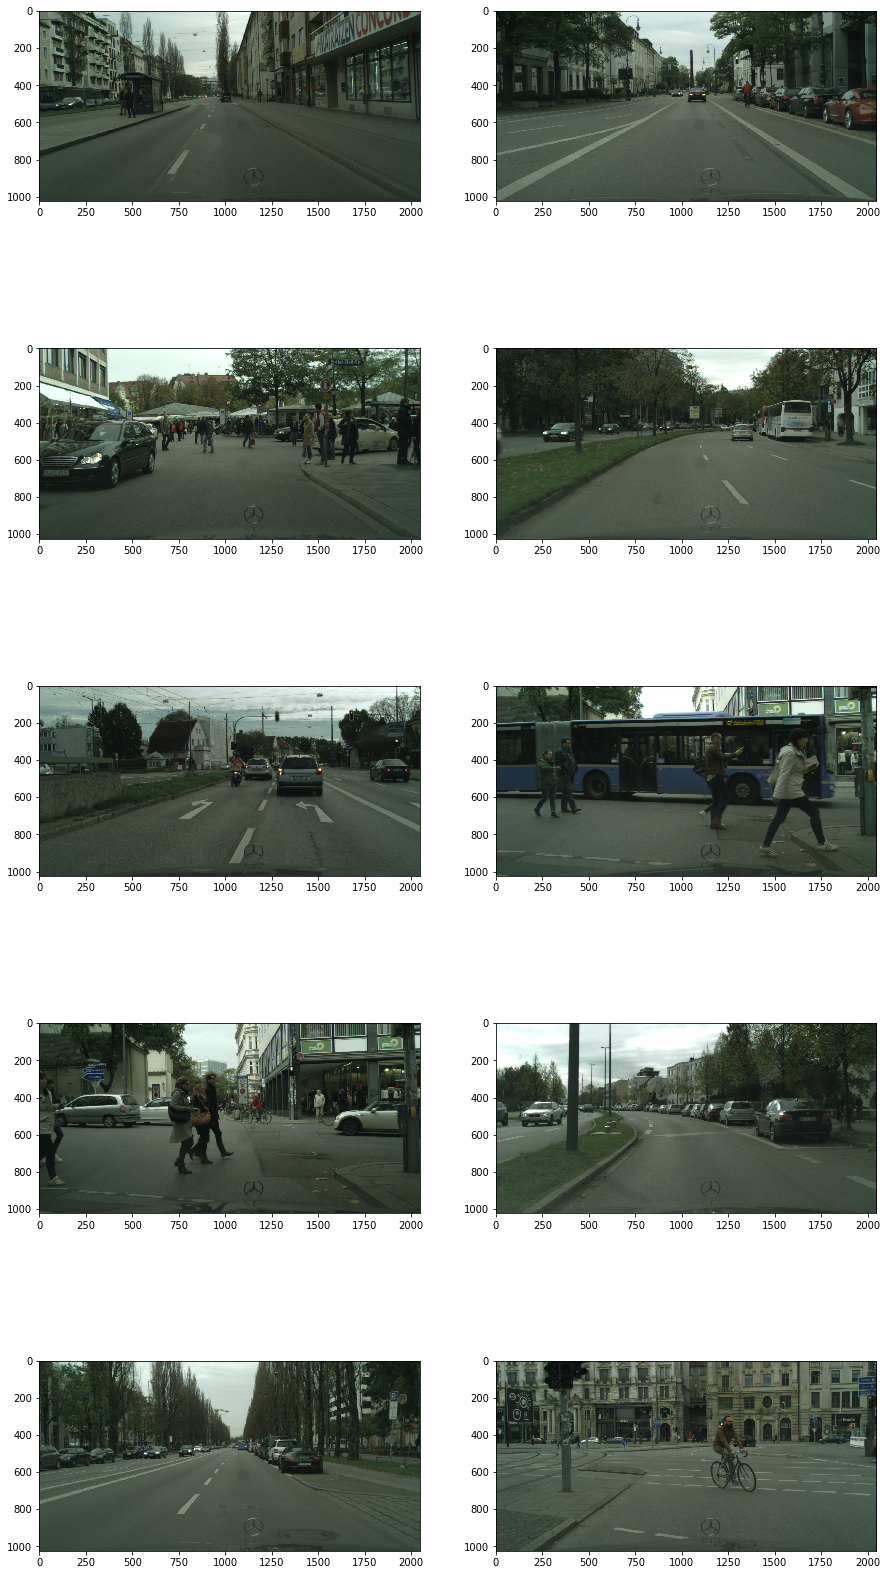

In [40]:
fig = plt.figure(figsize=(a,b))

for i in range(10):
    ax = fig.add_subplot(5, 2, i+1)
    ax.imshow(test_img[i][0])

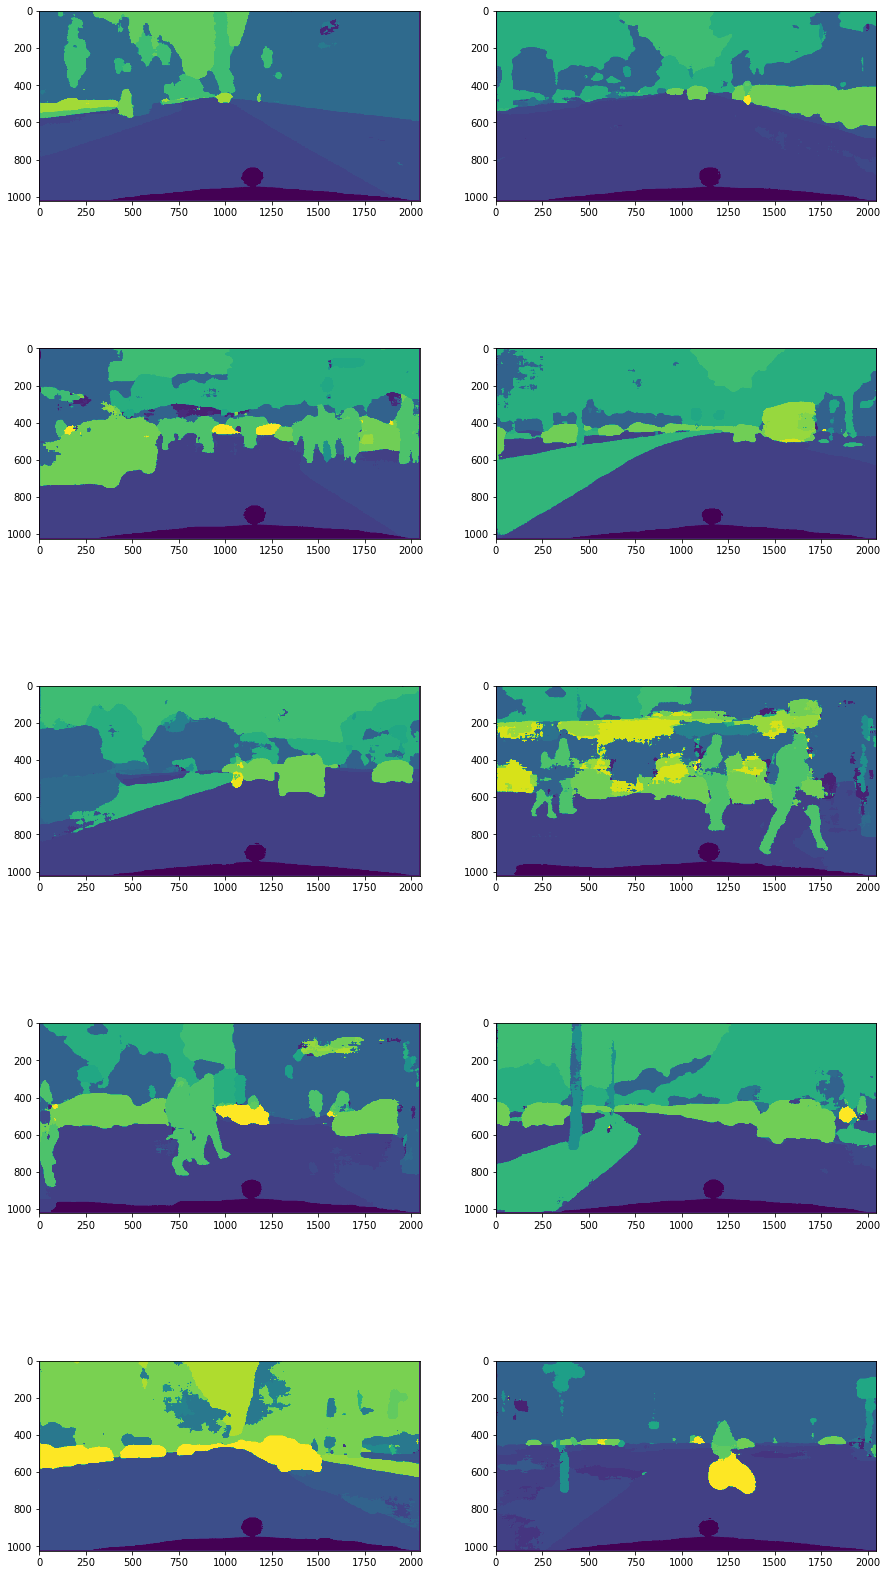

In [41]:
fig = plt.figure(figsize=(a,b))

for i in range(10):
    ax = fig.add_subplot(5, 2, i+1)
    y_img = test_transform(y_preds[i])
    ax.imshow(y_img)

In [46]:
fig = plt.figure(figsize=(a,b))

for i in range(1525):
    y_img = test_transform(y_preds[i])
    ax.imshow(y_img)
    y_img.save("/root/km/results/KMNet/200203_BlurNet/pred_"+str(i+1)+".png")

<Figure size 1080x2160 with 0 Axes>

In [44]:
fig = plt.figure(figsize=(a,b))

for i in range(1525):
    y_img = test_transform(y_preds[i])
    ax.imshow(y_img)
    y_img.save("/root/km/results/KMNet/200203_no blur VGG enc-dec/pred_"+str(i+1)+".png")

AttributeError: 'Cityscapes' object has no attribute 'shape'